In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score 
from sklearn.metrics import confusion_matrix, classification_report

from models import *

In [2]:
# 한글 폰트 깨지지 않게 하기
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = 'NanumGothic'
# 실행결과 경고메시지 출력 제외
import warnings

warnings.filterwarnings('ignore')

In [3]:
raw_data = pd.read_csv("../../01.files/02.Bigsata_analysis/통신고객이탈.csv", encoding = 'euc-kr')
raw_data.head()

,CHURN,CUSTOMER_ID,GENDER,AGE,CHARGE_TYPE,HANDSET,USAGE_BAND,SERVICE_DURATION,DROPPED_CALLS,PEAK_CALLS_NO,PEAK_CALLS_TIME,WEEKEND_CALLS_NO,WEEKEND_CALLS_TIME,TOTAL_CALLS_NO,TOTAL_CALLS_TIME
0,Active,K102990,F,31,CAT 100,ASAD170,Med,33.33,6,218,379.8,9,21.6,366,632.4
1,Active,K103280,M,27,CAT 100,S50,Med,30.87,10,373,656.4,11,28.0,411,810.4
2,Active,K103660,M,27,CAT 100,ASAD170,Med,49.40,11,260,582.0,0,0.0,265,614.1
3,Active,K103730,M,61,CAT 100,ASAD170,Med,48.60,1,294,661.8,14,101.5,326,844.0
4,Active,K104560,F,52,CAT 100,S50,Med,56.03,0,221,555.6,7,25.0,274,673.0


In [4]:
raw_data['CHURN'].unique()

array(['Active', 'Churned'], dtype=object)

In [5]:
raw_data.isnull().sum(axis = 0)

CHURN                 0
CUSTOMER_ID           0
GENDER                0
AGE                   0
CHARGE_TYPE           0
HANDSET               0
USAGE_BAND            0
SERVICE_DURATION      0
DROPPED_CALLS         0
PEAK_CALLS_NO         0
PEAK_CALLS_TIME       0
WEEKEND_CALLS_NO      0
WEEKEND_CALLS_TIME    0
TOTAL_CALLS_NO        0
TOTAL_CALLS_TIME      0
dtype: int64

In [6]:
df_raw_x = raw_data.drop(['CHURN','CUSTOMER_ID'], axis = 1)
df_raw_y = raw_data['CHURN'].map({'Active':1, 'Churned':0})

df_raw_x = pd.get_dummies(df_raw_x)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, # 설명변수 데이터
                                                                df_raw_y, # 목표변수 데이터
                                                                test_size = 0.3, # test 데이터의 비율
                                                                random_state = 1234)  # random state

print("분할 전 설명변수 데이터 :", df_raw_x.shape)
print("분할 후 설명변수 데이터 :Train", df_train_x.shape, "  Test",df_test_x.shape)

분할 전 설명변수 데이터 : (930, 33)
분할 후 설명변수 데이터 :Train (651, 33)   Test (279, 33)


### Random Forest

In [7]:
rf_uncust = RandomForestClassifier(random_state=1234)
rf_uncust.fit(df_train_x, df_train_y)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_uncust.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}".format(rf_uncust.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.907


In [8]:
rf_uncust.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

In [9]:
# default 파라미터 세팅

hyperparameters = {
    'min_samples_leaf' : [1],
    'min_samples_split' : [2],
    'max_depth' : [None],
    'n_estimators' : [100]
}         

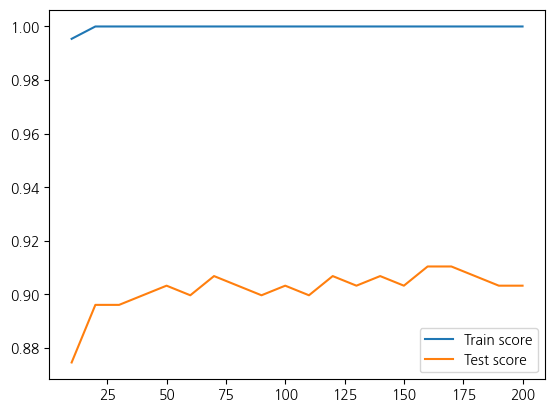

In [11]:
model_name = 'rf'

# n_estimators 조정
hyperparameters['n_estimators'] = [x * 10 for x in range(1,21)]
df_score = run_models_classification(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'n_estimators', 1)

In [12]:
df_score.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.995,0.875
1,20,1.000,0.896
2,30,1.000,0.896
3,40,1.000,0.900
4,50,1.000,0.903
5,60,1.000,0.900
6,70,1.000,0.907
7,80,1.000,0.903
8,90,1.000,0.900
9,100,1.000,0.903


Text(0.5, 0, 'n_estimators')

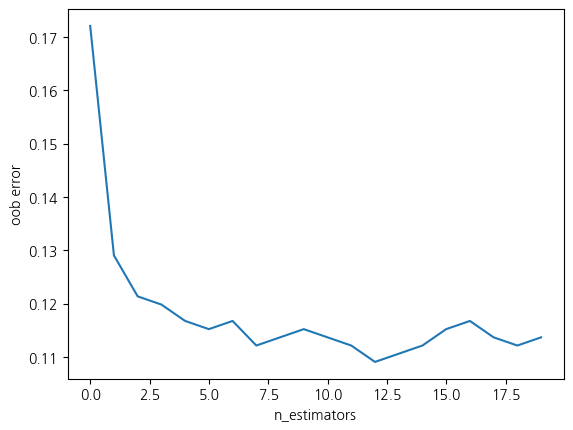

In [13]:
# error 저장 리스트
oob_error = []

for v_n_estimator in hyperparameters['n_estimators']:
    rf = RandomForestClassifier(n_estimators = v_n_estimator, oob_score = True, random_state= 1234)
    rf.fit(df_train_x, df_train_y)
    oob_error.append(1 - rf.oob_score_)

# 그래프로 표현
plt.plot(range(len(hyperparameters['n_estimators'])), oob_error)
plt.ylabel("oob error")
plt.xlabel("n_estimators")

In [14]:
hyperparameters['n_estimators'] = [120]

### oob 최저점 근처의 파라미터로 선택 => 120

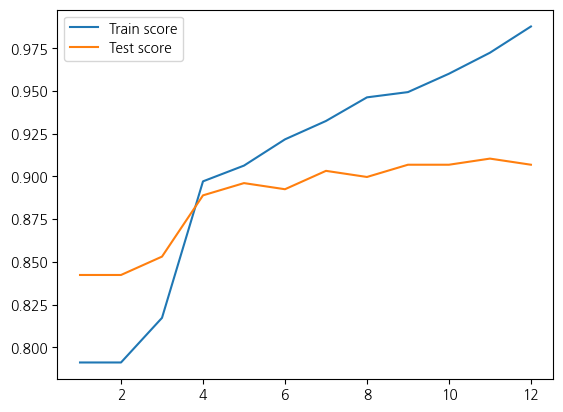

In [15]:
hyperparameters['max_depth'] = [x for x in range(1,13)]
df_score_depth = run_models_classification(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'max_depth', 1)

In [16]:
hyperparameters['max_depth'] = [5]

### test 데이터에 대한 성능이 낮아지기 전인 5로 선택

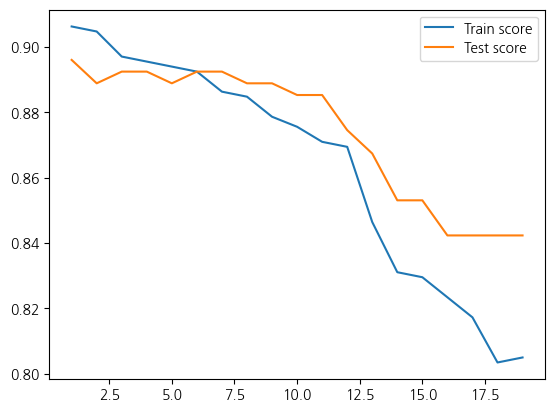

In [17]:
# min_samples_leaf 조정

hyperparameters['min_samples_leaf'] = [x for x in range(1,20)]
df_score = run_models_classification(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'min_samples_leaf', 1)

In [18]:
df_score.round(3)

,min_samples_leaf,TrainScore,TestScore
0,1,0.906,0.896
1,2,0.905,0.889
2,3,0.897,0.892
3,4,0.896,0.892
4,5,0.894,0.889
5,6,0.892,0.892
6,7,0.886,0.892
7,8,0.885,0.889
8,9,0.879,0.889
9,10,0.876,0.885


In [19]:
hyperparameters['min_samples_leaf'] = [5]

### leaf수가 2일대 가장 최적값처럼 보이나, 과적합 방지를 위해 그 다음 최고값인 5를 선택

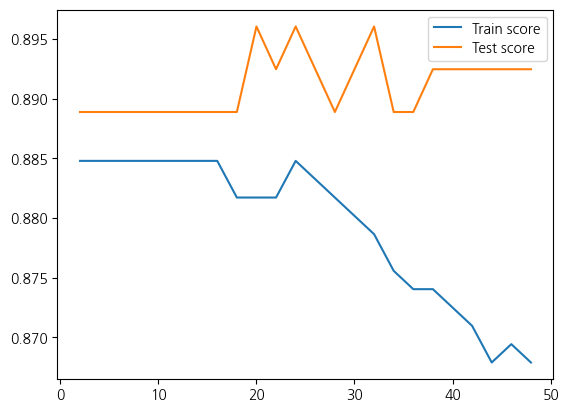

In [20]:
hyperparameters['min_samples_split'] = [x*2 for x in range(1,25)]
df_score_split = run_models_classification(hyperparameters, df_train_x, df_train_y, df_test_x, df_test_y, model_name, 'min_samples_split',1)

In [21]:
df_score_split.round(3)

,min_samples_split,TrainScore,TestScore
0,2,0.885,0.889
1,4,0.885,0.889
2,6,0.885,0.889
3,8,0.885,0.889
4,10,0.885,0.889
5,12,0.885,0.889
6,14,0.885,0.889
7,16,0.885,0.889
8,18,0.882,0.889
9,20,0.882,0.896


In [22]:
hyperparameters['min_samples_split'] = [20]

### test 셋에 대한 성능이 가장 높은 20 선택

In [23]:
hyperparameters

{'min_samples_leaf': [8],
 'min_samples_split': [20],
 'max_depth': [5],
 'n_estimators': [120]}

In [24]:
# 최종 모델
v_feature_name = df_train_x.columns
rf_final = RandomForestClassifier(n_estimators=hyperparameters['n_estimators'][0],
                                 min_samples_leaf = hyperparameters['min_samples_leaf'][0], 
                                 min_samples_split = hyperparameters['min_samples_split'][0],
                                 max_depth = hyperparameters['max_depth'][0],
                                 random_state=1234 )

rf_final.fit(df_train_x, df_train_y)
rf_final.get_params()

# 평가
y_pred = rf_final.predict(df_test_x)

# train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
# test 데이터 정확도
print("Accuracy on test set: {:.3f}\n".format(rf_final.score(df_test_x, df_test_y)))
# confusion matrix
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

# 목표변수의 빈도 불균형 : f1 score로 모델 평가 
print(classification_report(df_test_y, y_pred, digits=3))

Accuracy on training set: 0.879
Accuracy on test set: 0.864

Confusion matrix: 
[[ 10  34]
 [  4 231]]
              precision    recall  f1-score   support

           0      0.714     0.227     0.345        44
           1      0.872     0.983     0.924       235

    accuracy                          0.864       279
   macro avg      0.793     0.605     0.634       279
weighted avg      0.847     0.864     0.833       279



이탈하는 사람에 대한 예측(TP)수치가 가장 높으며 그에 따라       
recall이 가장 높은 것을 확인할 수 있음.

### 변수중요도

In [25]:
# 변수명
feature_names = df_train_x.columns

df_importance = pd.DataFrame()
df_importance["Feature"] = feature_names
df_importance["Importance"] = rf_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
17,HANDSET_ASAD90,0.229
2,DROPPED_CALLS,0.163
20,HANDSET_CAS30,0.099
8,TOTAL_CALLS_TIME,0.088
4,PEAK_CALLS_TIME,0.073
1,SERVICE_DURATION,0.048
3,PEAK_CALLS_NO,0.045
16,HANDSET_ASAD170,0.037
0,AGE,0.035
26,HANDSET_WC95,0.033


Text(0, 0.5, '설명변수')

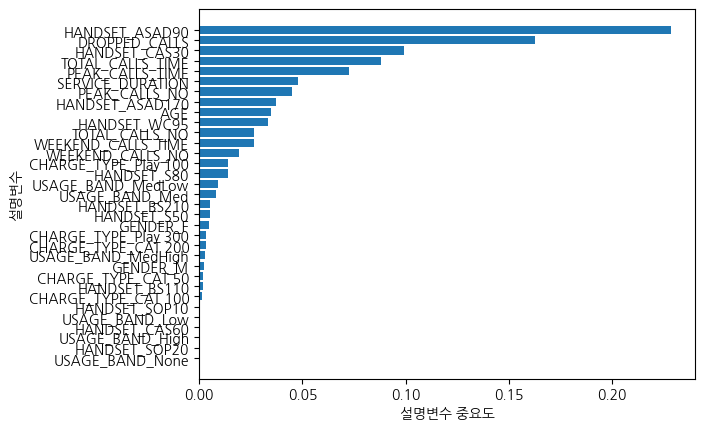

In [26]:
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance ))
plt.barh(y = coordinates, width = df_importance ["Importance"])
plt.yticks(coordinates, df_importance ["Feature"])
plt.xlabel("설명변수 중요도")
plt.ylabel("설명변수")